In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import socket, struct
import netaddr
from sklearn.cluster import KMeans



In [99]:
df = pd.read_csv('capture20110815-2.pcap.netflow.labeled.csv')

#preprocessing
df = df[df['Label']!='Background']

ips = df['SrcIPAddr:Port'].str.split(':')
df['SrcIPAddr'] = ips.str[0]
df['SrcIPPort'] = ips.str[-1]
ips = df['DstIPAddr:Port'].str.split(':')
df['DstIPAddr'] = ips.str[0]
df['DstIPPort'] = ips.str[-1]

df = df.drop(['Date', 'Flow_start', 'tmp', 'Flows', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis=1)
df.head()

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Durat,Prot,Flags,Tos,Packets,Bytes,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort
1,0.444,TCP,FPA_,0,300,19566,LEGITIMATE,NaN,147.32.87.252,49218,147.32.80.13,3128
4,0.442,TCP,FPA_,0,579,728343,LEGITIMATE,NaN,147.32.80.13,3128,147.32.87.252,49218
8,0.019,TCP,FA_,0,2,132,LEGITIMATE,NaN,66.249.66.10,64580,147.32.87.36,80
10,0.000,TCP,FA_,0,1,66,LEGITIMATE,NaN,147.32.87.36,80,66.249.66.10,64580
36,4.965,TCP,A_,0,86,5160,LEGITIMATE,NaN,113.193.72.126,51809,147.32.87.36,80


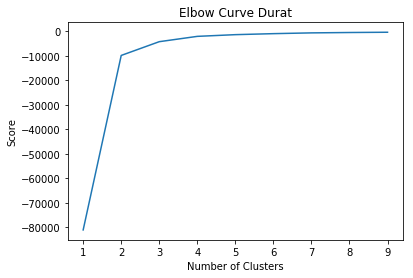

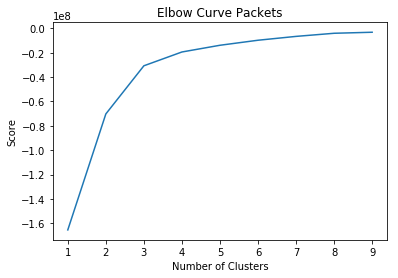

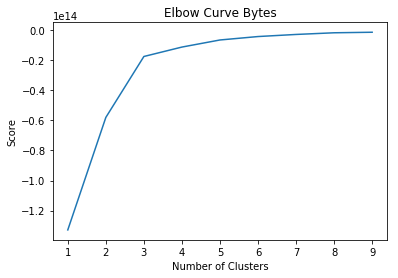

In [100]:
#clusters numerical
df_numerical = df[['Durat', 'Packets', 'Bytes']]
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
for column in df_numerical:
    X = df_numerical[column].values.reshape(-1, 1)
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve '+str(column))
    plt.show()

In [101]:
#elbow value identified from the above graphs
elbow = {'Durat': 2, 'Packets': 3, 'Bytes': 3}
for column in df_numerical:
    X = df_numerical[column].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=elbow[column], random_state=0).fit(X)
    df_numerical[column] = kmeans.labels_
    
df_numerical.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Durat,Packets,Bytes
1,0,2,0
4,0,2,1
8,0,0,0
10,0,0,0
36,1,0,0


In [102]:
#clusters text
df_text = df[['Prot', 'Flags', 'Tos', 'Label', 'Labels', 'SrcIPAddr', 'SrcIPPort', 'DstIPAddr', 'DstIPPort']] 
for column in df_text:
    labels, levels = pd.factorize(df_text[column])
    df_text[column] = labels

df_text.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Prot,Flags,Tos,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort
1,0,0,0,0,-1,0,0,0,0
4,0,0,0,0,-1,1,1,1,1
8,0,1,0,0,-1,2,2,2,2
10,0,1,0,0,-1,3,3,3,3
36,0,2,0,0,-1,4,4,2,2


In [113]:
df = pd.concat([df_text, df_numerical], axis=1)
code = 0
spaceSize = 1
for column in df:
    spaceSize = spaceSize * df[column].value_counts(dropna=True).count()
    
df.head()

,Prot,Flags,Tos,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort,Durat,Packets,Bytes
1,0,0,0,0,-1,0,0,0,0,0,2,0
4,0,0,0,0,-1,1,1,1,1,0,2,1
8,0,1,0,0,-1,2,2,2,2,0,0,0
10,0,1,0,0,-1,3,3,3,3,0,0,0
36,0,2,0,0,-1,4,4,2,2,1,0,0


In [122]:
#wip
codes = np.array([])
spaceSizeCurrent = spaceSize
for index, row in df.iterrows():
    for column in df:
        if (row[column] >= 0):
            code  = code + (row[column] * spaceSizeCurrent / df[column].value_counts(dropna=True).count())
            spaceSizeCurrent =  spaceSizeCurrent / df[column].value_counts(dropna=True).count()

    codes = np.append(codes,code)
    spaceSizeCurrent = spaceSize
    code = 0


df['codes'] = codes
df.head()

,Prot,Flags,Tos,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort,Durat,Packets,Bytes,codes
1,0,0,0,0,-1,0,0,0,0,0,2,0,1.200000e+01
4,0,0,0,0,-1,1,1,1,1,0,2,1,3.758824e+11
8,0,1,0,0,-1,2,2,2,2,0,0,0,1.766466e+14
10,0,1,0,0,-1,3,3,3,3,0,0,0,1.770225e+14
36,0,2,0,0,-1,4,4,2,2,1,0,0,3.532932e+14


In [123]:
#make plots
